# ExDEx Exercise 2 Code

**Group 7:** Dominik J. Gorickic, Brandon J. Nader, Manuel Petschinger, Michael Wolkerstorfer

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

In [21]:
path_cwd = os.getcwd()

Do countries with a higher share of organic agricultural area demonstrate higher or lower overall agricultural output or value-added per unit of land?

In [22]:
# Read the datasets
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [23]:

# 1. Clean the land use data

# Rename the first column
df_land_use = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})

# Split the metadata column
metadata_split = df_land_use['metadata'].str.split(',', expand=True)
df_land_use['freq'] = metadata_split[0]
df_land_use['so_eur'] = metadata_split[1]
df_land_use['crops'] = metadata_split[2]
df_land_use['unit'] = metadata_split[3]
df_land_use['geo_time'] = metadata_split[4]

# Split geo and time
df_land_use['geo'] = df_land_use['geo_time'].str.split('\\').str[0]
df_land_use['time_period'] = df_land_use['geo_time'].str.split('\\').str[1] if '\\' in df_land_use['geo_time'].iloc[0] else 'TIME_PERIOD'

# Clean year column names 
df_land_use.columns = [col.strip() if isinstance(col, str) else col for col in df_land_use.columns]

# Get year columns
year_cols = [col for col in df_land_use.columns if col.isdigit()]

# Filter for organic area and total UAA
organic_area = df_land_use[df_land_use['crops'] == 'UAAXK0000_ORG'].copy()
total_uua = df_land_use[df_land_use['crops'] == 'UAA'].copy()

# Melt organic area data
organic_melted = organic_area.melt(id_vars=['geo', 'crops'], 
                                  value_vars=year_cols,
                                  var_name='year', 
                                  value_name='organic_area_ha')
organic_melted['year'] = organic_melted['year'].astype(int)

# Melt total UAA data
total_uua_melted = total_uua.melt(id_vars=['geo', 'crops'],
                                 value_vars=year_cols,
                                 var_name='year',
                                 value_name='total_uua_ha')
total_uua_melted['year'] = total_uua_melted['year'].astype(int)

# Clean numeric values
def clean_numeric(value):
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN']:
            return np.nan
        # Remove flags 
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

organic_melted['organic_area_ha'] = organic_melted['organic_area_ha'].apply(clean_numeric)
total_uua_melted['total_uua_ha'] = total_uua_melted['total_uua_ha'].apply(clean_numeric)

# Merge and calculate organic share
organic_data = pd.merge(organic_melted[['geo', 'year', 'organic_area_ha']],
                       total_uua_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')
organic_data['organic_share'] = organic_data['organic_area_ha'] / organic_data['total_uua_ha']


In [24]:

# 2. Clean output data

df_output = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_output = df_output['metadata'].str.split(',', expand=True)
df_output['freq'] = metadata_split_output[0]
df_output['itm_newa'] = metadata_split_output[1]
df_output['indic_ag'] = metadata_split_output[2]
df_output['unit'] = metadata_split_output[3]
df_output['geo_time'] = metadata_split_output[4]

df_output['geo'] = df_output['geo_time'].str.split('\\').str[0]
df_output.columns = [col.strip() if isinstance(col, str) else col for col in df_output.columns]

# Get year columns for output
output_year_cols = [col for col in df_output.columns if col.isdigit()]

# Filter for basic prices 
output_data = df_output[df_output['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo', 'indic_ag'],
                                value_vars=output_year_cols,
                                var_name='year',
                                value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000  # Convert to EUR


In [25]:

# 3. Merge all data

# Merge output with total UAA 
output_with_area = pd.merge(output_melted[['geo', 'year', 'output_eur']],
                           total_uua_melted[['geo', 'year', 'total_uua_ha']],
                           on=['geo', 'year'], how='inner')

# Calculate output per hectare
output_with_area['output_per_ha'] = output_with_area['output_eur'] / output_with_area['total_uua_ha']

# Merge with organic share
final_data = pd.merge(organic_data[['geo', 'year', 'organic_share']],
                      output_with_area[['geo', 'year', 'output_per_ha']],
                      on=['geo', 'year'], how='inner')

# Remove missing values
final_data = final_data.dropna()

print(f"Total observations: {len(final_data)}")
print(f"Countries: {final_data['geo'].nunique()}")
print(f"Years: {final_data['year'].min()} to {final_data['year'].max()}")


Total observations: 110
Countries: 32
Years: 2013 to 2023



Overall correlation: -0.173


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4,
C:\Users\domin\AppData\Local\Temp\ipykernel_10888\1282478628.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=labels)


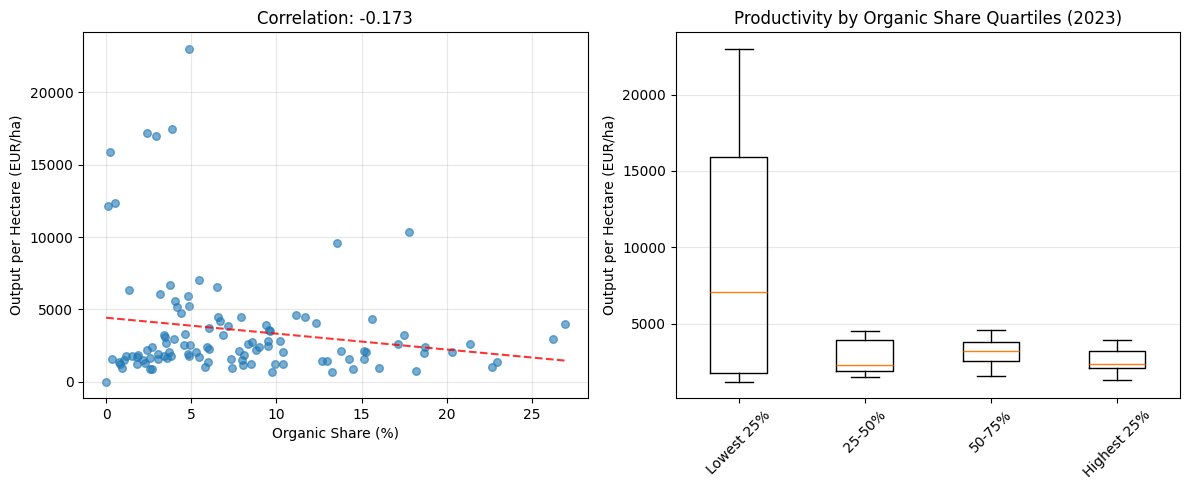

In [26]:

# 4. Analysis

# Correlation
correlation = final_data['organic_share'].corr(final_data['output_per_ha'])
print(f"\nOverall correlation: {correlation:.3f}")


# Visualization
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(final_data['organic_share'] * 100, final_data['output_per_ha'], 
           alpha=0.6, s=30)
plt.xlabel('Organic Share (%)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Correlation: {correlation:.3f}')
plt.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(final_data['organic_share'] * 100, final_data['output_per_ha'], 1)
p = np.poly1d(z)
x_range = np.linspace(0, final_data['organic_share'].max() * 100, 100)
plt.plot(x_range, p(x_range), "r--", alpha=0.8)

# Box plot comparison
plt.subplot(1, 2, 2)
latest_year = final_data['year'].max()
latest_data = final_data[final_data['year'] == latest_year]

# Create groups
latest_data['organic_group'] = pd.qcut(latest_data['organic_share'], q=4, 
                                      labels=['Lowest 25%', '25-50%', '50-75%', 'Highest 25%'])

# Data for box plot
box_data = []
labels = []
for group in ['Lowest 25%', '25-50%', '50-75%', 'Highest 25%']:
    group_data = latest_data[latest_data['organic_group'] == group]['output_per_ha']
    if len(group_data) > 0:
        box_data.append(group_data)
        labels.append(group)

plt.boxplot(box_data, labels=labels)
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Productivity by Organic Share Quartiles ({latest_year})')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [27]:

# 5. Results

# Top and bottom performers
print(f"\nTop 5 by organic share:")
top5 = latest_data.nlargest(5, 'organic_share')
for i, (_, row) in enumerate(top5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 by organic share:")
bottom5 = latest_data.nsmallest(5, 'organic_share')
for i, (_, row) in enumerate(bottom5.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")

# Summary statistics
print(f"\nSummary Statistics ({latest_year}):")
print(f"Average organic share: {latest_data['organic_share'].mean()*100:.1f}%")
print(f"Median organic share: {latest_data['organic_share'].median()*100:.1f}%")
print(f"Average output per hectare: {latest_data['output_per_ha'].mean():.0f} EUR/ha")
print(f"Median output per hectare: {latest_data['output_per_ha'].median():.0f} EUR/ha")

# Top vs bottom quartile
top_quartile = latest_data[latest_data['organic_group'] == 'Highest 25%']
bottom_quartile = latest_data[latest_data['organic_group'] == 'Lowest 25%']

print(f"\nComparison of highest vs lowest organic quartile:")
print(f"Highest 25% organic: {len(top_quartile)} countries, avg output: {top_quartile['output_per_ha'].mean():.0f} EUR/ha")
print(f"Lowest 25% organic: {len(bottom_quartile)} countries, avg output: {bottom_quartile['output_per_ha'].mean():.0f} EUR/ha")
difference = top_quartile['output_per_ha'].mean() - bottom_quartile['output_per_ha'].mean()
print(f"Difference: {difference:+.0f} EUR/ha ({difference/bottom_quartile['output_per_ha'].mean()*100:+.1f}%)")

# 6. Time trend analysis 
if final_data['year'].nunique() > 1:
    
    # Calculate average organic share and output per year
    yearly_stats = final_data.groupby('year').agg({
        'organic_share': 'mean',
        'output_per_ha': 'mean'
    }).reset_index()
    
    print(f"\nYearly averages:")
    for _, row in yearly_stats.iterrows():
        print(f"{row['year']}: {row['organic_share']*100:.1f}% organic, {row['output_per_ha']:.0f} EUR/ha")
    
    # Calculate changes
    if len(yearly_stats) >= 2:
        first_year = yearly_stats['year'].min()
        last_year = yearly_stats['year'].max()
        
        first_row = yearly_stats[yearly_stats['year'] == first_year].iloc[0]
        last_row = yearly_stats[yearly_stats['year'] == last_year].iloc[0]
        
        organic_change = (last_row['organic_share'] - first_row['organic_share']) / first_row['organic_share'] * 100
        output_change = (last_row['output_per_ha'] - first_row['output_per_ha']) / first_row['output_per_ha'] * 100
        
        print(f"\nChange from {first_year} to {last_year}:")
        print(f"Organic share: {organic_change:+.1f}%")
        print(f"Output per hectare: {output_change:+.1f}%")



Top 5 by organic share:
1. AT: 26.9% organic, 3963 EUR/ha
2. EE: 22.9% organic, 1342 EUR/ha
3. SE: 18.7% organic, 2391 EUR/ha
4. PT: 17.5% organic, 3243 EUR/ha
5. CZ: 15.3% organic, 2092 EUR/ha

Bottom 5 by organic share:
1. MT: 0.2% organic, 15893 EUR/ha
2. BG: 1.8% organic, 1221 EUR/ha
3. NL: 4.9% organic, 22984 EUR/ha
4. RO: 4.9% organic, 1770 EUR/ha
5. CY: 5.5% organic, 7053 EUR/ha

Summary Statistics (2023):
Average organic share: 10.6%
Median organic share: 9.4%
Average output per hectare: 4668 EUR/ha
Median output per hectare: 2843 EUR/ha

Comparison of highest vs lowest organic quartile:
Highest 25% organic: 5 countries, avg output: 2606 EUR/ha
Lowest 25% organic: 5 countries, avg output: 9784 EUR/ha
Difference: -7178 EUR/ha (-73.4%)

Yearly averages:
2013.0: 5.5% organic, 3316 EUR/ha
2016.0: 7.4% organic, 3121 EUR/ha
2020.0: 8.9% organic, 3563 EUR/ha
2023.0: 10.6% organic, 4668 EUR/ha

Change from 2013 to 2023:
Organic share: +91.1%
Output per hectare: +40.8%


Is there a relationship between farm manager training/age and the adoption of organic farming, higher-value production, or better economic results?

In [28]:
# Datasets
df_manager_age = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Age.tsv', sep='\t')
df_manager_training = pd.read_csv('EUROSTAT/Agricultural_Holdings_By_Manager_Training.tsv', sep='\t')
df_organic = pd.read_csv('EUROSTAT/Agricultural_Holdings_With_Organic_Area.tsv', sep='\t')
df_output = pd.read_csv('EUROSTAT/Output_of_the_agricultural_industry_basic_and_producer_prices_.tsv', sep='\t')
df_land_use = pd.read_csv('EUROSTAT/Farm_Land_Use.tsv', sep='\t')


In [29]:

# Function to clean numeric values
def clean_numeric(value):
    if pd.isna(value):
        return np.nan
    if isinstance(value, str):
        value = value.strip()
        if value in [':', '', 'nan', 'NaN', 'NAN']:
            return np.nan
        # Remove flags
        value = value.replace('i', '').replace('u', '').replace('e', '').replace('@', '').replace('C', '')
        try:
            return float(value)
        except:
            return np.nan
    return value

# 1. Process Manager Age Data 

# Rename first column
df_age = df_manager_age.rename(columns={df_manager_age.columns[0]: 'metadata'})

# Split metadata
metadata_split = df_age['metadata'].str.split(',', expand=True)
df_age['freq'] = metadata_split[0]
df_age['so_eur'] = metadata_split[1]
df_age['sex'] = metadata_split[2]
df_age['age'] = metadata_split[3]
df_age['unit'] = metadata_split[4]
df_age['geo_time'] = metadata_split[5]

# Get geo code
df_age['geo'] = df_age['geo_time'].str.split('\\').str[0]

# Clean column names
df_age.columns = [str(col).strip() for col in df_age.columns]

# Get year columns
age_year_cols = [col for col in df_age.columns if col.isdigit()]

# Filter for relevant data: TOTAL sex and TOTAL age and young age groups
df_age_total = df_age[(df_age['sex'] == 'T') & (df_age['age'] == 'TOTAL')].copy()
df_age_young = df_age[(df_age['sex'] == 'T') & (df_age['age'].isin(['Y_LT25', 'Y25-34', 'Y35-39', 'Y40-44']))].copy()

# Melt total holders data
age_total_melted = df_age_total.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='total_holders')
age_total_melted['year'] = age_total_melted['year'].astype(int)
age_total_melted['total_holders'] = age_total_melted['total_holders'].apply(clean_numeric)

# Melt young holders data
age_young_melted = df_age_young.melt(id_vars=['geo', 'age'], 
                                     value_vars=age_year_cols,
                                     var_name='year', 
                                     value_name='young_holders')
age_young_melted['year'] = age_young_melted['year'].astype(int)
age_young_melted['young_holders'] = age_young_melted['young_holders'].apply(clean_numeric)

# Sum all young age groups per country/year
young_summary = age_young_melted.groupby(['geo', 'year'])['young_holders'].sum().reset_index()

# Merge with total holders
age_data = pd.merge(young_summary, 
                    age_total_melted[['geo', 'year', 'total_holders']],
                    on=['geo', 'year'], how='inner')

# Calculate young manager share (under 45)
age_data['young_share'] = age_data['young_holders'] / age_data['total_holders']


In [30]:

# 2.  Organic Data

# Clean organic data
df_org = df_organic.rename(columns={df_organic.columns[0]: 'metadata'})
metadata_split_org = df_org['metadata'].str.split(',', expand=True)
df_org['freq'] = metadata_split_org[0]
df_org['uaarea'] = metadata_split_org[1]
df_org['so_eur'] = metadata_split_org[2]
df_org['farmtype'] = metadata_split_org[3]
df_org['crops'] = metadata_split_org[4]
df_org['unit'] = metadata_split_org[5]
df_org['geo_time'] = metadata_split_org[6]
df_org['geo'] = df_org['geo_time'].str.split('\\').str[0]

# Clean column names
df_org.columns = [str(col).strip() for col in df_org.columns]
org_year_cols = [col for col in df_org.columns if col.isdigit()]

# Filter for organic holdings
org_data = df_org[df_org['crops'] == 'UAAXK0000_ORG'].copy()

# Melt organic data
org_melted = org_data.melt(id_vars=['geo', 'crops'], 
                           value_vars=org_year_cols,
                           var_name='year', 
                           value_name='organic_holdings')
org_melted['year'] = org_melted['year'].astype(int)
org_melted['organic_holdings'] = org_melted['organic_holdings'].apply(clean_numeric)


In [31]:

# 3. Data for Economic Results

# Clean output data
df_out = df_output.rename(columns={df_output.columns[0]: 'metadata'})
metadata_split_out = df_out['metadata'].str.split(',', expand=True)
df_out['freq'] = metadata_split_out[0]
df_out['itm_newa'] = metadata_split_out[1]
df_out['indic_ag'] = metadata_split_out[2]
df_out['unit'] = metadata_split_out[3]
df_out['geo_time'] = metadata_split_out[4]
df_out['geo'] = df_out['geo_time'].str.split('\\').str[0]

# Clean column names
df_out.columns = [str(col).strip() for col in df_out.columns]
out_year_cols = [col for col in df_out.columns if col.isdigit()]

# Get output value (basic prices)
output_data = df_out[df_out['indic_ag'] == 'PROD_BP'].copy()

# Melt output data
output_melted = output_data.melt(id_vars=['geo'], 
                                 value_vars=out_year_cols,
                                 var_name='year', 
                                 value_name='output_mio_eur')
output_melted['year'] = output_melted['year'].astype(int)
output_melted['output_mio_eur'] = output_melted['output_mio_eur'].apply(clean_numeric)
output_melted['output_eur'] = output_melted['output_mio_eur'] * 1000000


In [32]:

# 4. Land Use Data for area

# Clean land use data
df_land = df_land_use.rename(columns={df_land_use.columns[0]: 'metadata'})
metadata_split_land = df_land['metadata'].str.split(',', expand=True)
df_land['freq'] = metadata_split_land[0]
df_land['so_eur'] = metadata_split_land[1]
df_land['crops'] = metadata_split_land[2]
df_land['unit'] = metadata_split_land[3]
df_land['geo_time'] = metadata_split_land[4]
df_land['geo'] = df_land['geo_time'].str.split('\\').str[0]

# Clean column names
df_land.columns = [str(col).strip() for col in df_land.columns]
land_year_cols = [col for col in df_land.columns if col.isdigit()]

# Get total UAA
land_total = df_land[df_land['crops'] == 'UAA'].copy()

# Melt land data
land_melted = land_total.melt(id_vars=['geo'], 
                              value_vars=land_year_cols,
                              var_name='year', 
                              value_name='total_uua_ha')
land_melted['year'] = land_melted['year'].astype(int)
land_melted['total_uua_ha'] = land_melted['total_uua_ha'].apply(clean_numeric)


In [33]:

# 5. Merge All Data

# Start with age data
merged_data = age_data[['geo', 'year', 'young_share']].copy()

# Merge with organic
merged_data = pd.merge(merged_data, 
                       org_melted[['geo', 'year', 'organic_holdings']],
                       on=['geo', 'year'], how='inner')

# Merge with land area
merged_data = pd.merge(merged_data, 
                       land_melted[['geo', 'year', 'total_uua_ha']],
                       on=['geo', 'year'], how='inner')

# Merge with output
merged_data = pd.merge(merged_data, 
                       output_melted[['geo', 'year', 'output_eur']],
                       on=['geo', 'year'], how='inner')

# Calculate derived metrics
# Organic share = organic holdings / total UAA (approximate)
merged_data['organic_share'] = merged_data['organic_holdings'] / merged_data['total_uua_ha']
merged_data['output_per_ha'] = merged_data['output_eur'] / merged_data['total_uua_ha']

# Remove rows with missing data
merged_data = merged_data.dropna()

print(f"\nData ready for analysis!")
print(f"Total observations: {len(merged_data)}")
print(f"Countries: {merged_data['geo'].nunique()}")
print(f"Years: {merged_data['year'].min()} to {merged_data['year'].max()}")

# 6. Analysis

# Get latest year data
latest_year = merged_data['year'].max()
latest_data = merged_data[merged_data['year'] == latest_year].copy()

print(f"\nAnalysis for {latest_year}:")
print(f"Countries: {len(latest_data)}")

# Correlation
corr_organic = latest_data['young_share'].corr(latest_data['organic_share'])
corr_output = latest_data['young_share'].corr(latest_data['output_per_ha'])

print(f"\nCorrelations:")
print(f"Young managers vs Organic share: {corr_organic:.3f}")
print(f"Young managers vs Output per hectare: {corr_output:.3f}")



Data ready for analysis!
Total observations: 110
Countries: 32
Years: 2013 to 2023

Analysis for 2023:
Countries: 19

Correlations:
Young managers vs Organic share: -0.244
Young managers vs Output per hectare: -0.244


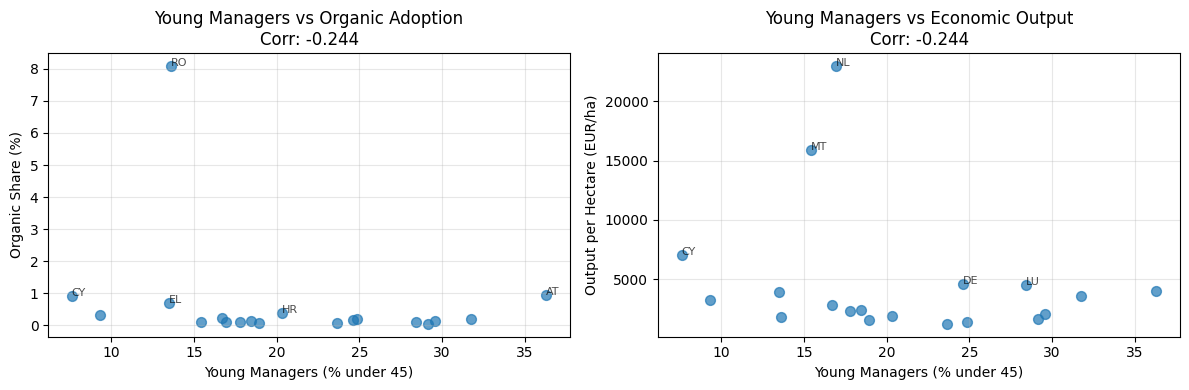

In [34]:

# 7. Visualization
plt.figure(figsize=(12, 4))

# Plot 1: Young managers vs Organic
plt.subplot(1, 2, 1)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['organic_share'] * 100, 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Organic Share (%)')
plt.title(f'Young Managers vs Organic Adoption\nCorr: {corr_organic:.3f}')
plt.grid(True, alpha=0.3)

top_organic = latest_data.nlargest(5, 'organic_share')
for _, row in top_organic.iterrows():
    plt.text(row['young_share'] * 100, row['organic_share'] * 100, 
             row['geo'], fontsize=8, alpha=0.7)

# Plot 2: Young managers vs Output
plt.subplot(1, 2, 2)
plt.scatter(latest_data['young_share'] * 100, 
            latest_data['output_per_ha'], 
            alpha=0.7, s=50)
plt.xlabel('Young Managers (% under 45)')
plt.ylabel('Output per Hectare (EUR/ha)')
plt.title(f'Young Managers vs Economic Output\nCorr: {corr_output:.3f}')
plt.grid(True, alpha=0.3)

top_output = latest_data.nlargest(5, 'output_per_ha')
for _, row in top_output.iterrows():
    plt.text(row['young_share'] * 100, row['output_per_ha'], 
             row['geo'], fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()


In [ ]:
# 8. Analysis

# Compare top and bottom quartiles by young manager share
latest_data['young_quartile'] = pd.qcut(latest_data['young_share'], q=2, 
                                       labels=['Bottom 50%', 'Top 50%'])

young_stats = latest_data.groupby('young_quartile').agg({
    'organic_share': 'mean',
    'output_per_ha': 'mean',
    'geo': 'count'
}).round(4)

print(f"\nAverage values:")
print(f"{'':<15} {'Countries':<10} {'Organic %':<12} {'Output EUR/ha':<15}")
print("-" * 50)
for quartile in ['Bottom 50%', 'Top 50%']:
    stats = young_stats.loc[quartile]
    print(f"{quartile:<15} {int(stats['geo']):<10} {stats['organic_share']*100:.1f}%{'':<4} {stats['output_per_ha']:.0f}")



Average values:
                Countries  Organic %    Output EUR/ha  
--------------------------------------------------
Bottom 50%      10         1.1%     6391
Top 50%         9          0.2%     2755


C:\Users\domin\AppData\Local\Temp\ipykernel_10888\3791994956.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  young_stats = latest_data.groupby('young_quartile').agg({


In [36]:

# 9. Examples
print("\n" + "="*70)
print("COUNTRY EXAMPLES")

print(f"\nTop 5 countries by young manager share:")
top_young = latest_data.nlargest(5, 'young_share')
for i, (_, row) in enumerate(top_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

print(f"\nBottom 5 countries by young manager share:")
bottom_young = latest_data.nsmallest(5, 'young_share')
for i, (_, row) in enumerate(bottom_young.iterrows(), 1):
    print(f"{i}. {row['geo']}: {row['young_share']*100:.1f}% young, "
          f"{row['organic_share']*100:.1f}% organic, "
          f"{row['output_per_ha']:.0f} EUR/ha")

# 10. Summary

print(f"\n3. FINDINGS:")
print(f"   Countries with most young managers have {young_stats.loc['Top 50%', 'organic_share']*100:.1f}% organic")
print(f"   Countries with fewest young managers have {young_stats.loc['Bottom 50%', 'organic_share']*100:.1f}% organic")

organic_diff = (young_stats.loc['Top 50%', 'organic_share'] - young_stats.loc['Bottom 50%', 'organic_share']) / young_stats.loc['Bottom 50%', 'organic_share'] * 100
output_diff = (young_stats.loc['Top 50%', 'output_per_ha'] - young_stats.loc['Bottom 50%', 'output_per_ha']) / young_stats.loc['Bottom 50%', 'output_per_ha'] * 100

print(f"   Difference: {organic_diff:+.1f}% in organic adoption")
print(f"   Difference: {output_diff:+.1f}% in output per hectare")


COUNTRY EXAMPLES

Top 5 countries by young manager share:
1. AT: 36.3% young, 0.9% organic, 3963 EUR/ha
2. FR: 31.7% young, 0.2% organic, 3565 EUR/ha
3. CZ: 29.5% young, 0.1% organic, 2092 EUR/ha
4. SK: 29.2% young, 0.1% organic, 1612 EUR/ha
5. LU: 28.4% young, 0.1% organic, 4509 EUR/ha

Bottom 5 countries by young manager share:
1. CY: 7.6% young, 0.9% organic, 7053 EUR/ha
2. PT: 9.3% young, 0.3% organic, 3243 EUR/ha
3. EL: 13.5% young, 0.7% organic, 3922 EUR/ha
4. RO: 13.6% young, 8.1% organic, 1770 EUR/ha
5. MT: 15.4% young, 0.1% organic, 15893 EUR/ha

3. FINDINGS:
   Countries with most young managers have 0.2% organic
   Countries with fewest young managers have 1.1% organic
   Difference: -76.9% in organic adoption
   Difference: -56.9% in output per hectare


## Crop Yields vs. Climatic Anomalies

To what extent can deviations in European crop yields (2000–2024) be explained by regional climatic
anomalies (temperature and precipitation)?

- Do Southern European countries (e.g., Spain, Italy) show a stronger negative correlation between rising summer temperatures and crop yields compared to Northern European countries (e.g., Sweden, Germany)?

- Is the yield volatility (year-to-year variation) increasing more for rain-fed crops (e.g., wheat) than for irrigated/hardier crops (e.g., olives/grapes)?

- How well can future trends be predicted?

### Copernicus Climate Change Service (C3S) Data Import

First, we use the Climate Data Store (CDS) API to load data temperature and precipitation flux data:

**1. temp_max (Daily Maximum Air Temperature):**

- Scientific Definition: The highest temperature recorded at 2 meters height above the land surface within the 24-hour period.

- Unit: The raw data is in Kelvin (K).

- Why it matters for our analysis: This is the "Heat Stress" indicator. Agriculture is more sensitive to extremes than averages. Even if the average temperature is normal, a single week where temp_max exceeds 30°C or 35°C (depending on the crop) can sterilize pollen or halt grain filling, destroying the harvest.

**2. precip (Precipitation Flux):**

- Scientific Definition: The total volume of water (liquid rain or frozen snow) that reaches the ground per unit area over the 24-hour period.

- Unit: Millimeters (mm) per day, which is equivalent to Liters per square meter ($L/m^2$).

- Why it matters for our analysis: This is your "Water Availability" indicator. You will use this to identify:

    - Droughts: Extended periods during the growing season (April–July) where the cumulative precip is significantly below the 20-year average.
    
    - Floods: Sudden, extreme spikes in precip that can wash away seeds or rot roots.

To run the cell below, we have to create an account on https://cds.climate.copernicus.eu/how-to-api and follow the instructions on the cite to save the API credentials on our local machine.

In [ ]:
import cdsapi
import os

"""
# -- Define the Europe bounding box [North, West, South, East]
EUROPE_AREA = [72, -25, 34, 45]

dataset = "sis-agrometeorological-indicators"
client = cdsapi.Client()

# -- Automate month and day lists
months = [f"{i:02d}" for i in range(1, 13)]
days = [f"{i:02d}" for i in range(1, 32)]

# -- Define the variables we want to download (separated because they require different parameters)
data_configs = [
    {
        "name": "temp_max",  # for filename
        "params": {
            "variable": "2m_temperature",
            "statistic": "24_hour_maximum"
        }
    },
    {
        "name": "precip",    # for filename
        "params": {
            "variable": "precipitation_flux"
            # Note: 'statistic' is removed here as it is not valid for flux
        }
    }
]

# -- Loop through years and variables
for year in range(2000, 2025):
    year_str = str(year)
    
    for config in data_configs:
        # Construct a unique filename for this variable/year combination
        output_file = f"agera5_europe_{config['name']}_{year_str}.zip"
        
        # Skip if already downloaded
        if os.path.exists(output_file):
            print(f"Skipping {output_file}, already exists.")
            continue
        
        print(f"Requesting {config['name']} for {year_str}...")
        
        # Base request with common parameters
        request = {
            "year": year_str,
            "month": months,
            "day": days,
            "version": "1_1",
            "format": "zip",
            "area": EUROPE_AREA
        }
        
        # Update request with specific variable parameters (variable name + statistic)
        request.update(config['params'])

        try:
            client.retrieve(dataset, request, output_file)
            print(f"Download complete: {output_file}")
        except Exception as e:
            print(f"Failed to download {output_file}: {e}")
"""

Since we downloaded zip-files that include lots of .nc files, we need to further process the data. In the next step, we extract only the relevant data for the EU-27 countries. Our project has a strong focus on agriculture which is why we select a well-known agricultural region for each country. The countries and their specific coordinates are listed below. Our goal is to output a csv-file that contains the temperature and precipitation flux data for each day from 2000 to 2024 and for each EU-27 country.

In [ ]:
import zipfile
import os
import glob
import xarray as xr
import pandas as pd
import shutil

ZIP_FOLDER = "./"            
TEMP_EXTRACT_FOLDER = "./temp_nc_files"
OUTPUT_CSV = "./C3S/europe_climate_by_location_2000_2024.csv"

# -- List of EU-27 Agricultural Regions (approximate centroids)
LOCATIONS = [
    {'name': 'Austria_Marchfeld',       'lat': 48.20, 'lon': 16.70}, # Major crop area
    {'name': 'Belgium_Hesbaye',         'lat': 50.60, 'lon': 5.20},  # Arable farming
    {'name': 'Bulgaria_Thrace',         'lat': 42.15, 'lon': 24.75}, # Thracian Plain
    {'name': 'Croatia_Slavonia',        'lat': 45.55, 'lon': 18.69}, # Major breadbasket
    {'name': 'Cyprus_Messaoria',        'lat': 35.15, 'lon': 33.35}, # Central plain
    {'name': 'Czechia_Moravia',         'lat': 49.20, 'lon': 16.60}, # Fertile lowlands
    {'name': 'Denmark_Jutland',         'lat': 56.15, 'lon': 9.50},  # Intensive agriculture
    {'name': 'Estonia_Central',         'lat': 58.80, 'lon': 25.60},
    {'name': 'Finland_Varsinais',       'lat': 60.45, 'lon': 23.10}, # Southwest farmlands
    {'name': 'France_CentreValLoire',   'lat': 47.90, 'lon': 1.90},  # The "breadbasket" of France
    {'name': 'Germany_LowerSaxony',     'lat': 52.37, 'lon': 9.73},  # Major arable region
    {'name': 'Greece_Thessaly',         'lat': 39.60, 'lon': 22.40}, # Major agricultural plain
    {'name': 'Hungary_GreatPlain',      'lat': 47.18, 'lon': 20.19}, # Alföld region
    {'name': 'Ireland_Munster',         'lat': 52.25, 'lon': -8.65}, # Dairy/Grazing
    {'name': 'Italy_EmiliaRomagna',     'lat': 44.50, 'lon': 11.35}, # Po Valley (intensive)
    {'name': 'Latvia_Zemgale',          'lat': 56.65, 'lon': 23.70}, # "Breadbasket" of Latvia
    {'name': 'Lithuania_Central',       'lat': 55.17, 'lon': 23.88},
    {'name': 'Luxembourg_Gutland',      'lat': 49.75, 'lon': 6.10},
    {'name': 'Malta_Rural',             'lat': 35.90, 'lon': 14.40},
    {'name': 'Netherlands_Flevoland',   'lat': 52.50, 'lon': 5.50},  # Reclaimed agricultural land
    {'name': 'Poland_Wielkopolska',     'lat': 52.40, 'lon': 16.90}, # Intensive farming
    {'name': 'Portugal_Alentejo',       'lat': 38.00, 'lon': -7.80}, # Major crop region
    {'name': 'Romania_Baragan',         'lat': 44.90, 'lon': 27.00}, # Baragan Plain (cereals)
    {'name': 'Slovakia_Danubian',       'lat': 48.00, 'lon': 17.60}, # Fertile lowlands
    {'name': 'Slovenia_Drava',          'lat': 46.55, 'lon': 15.65},
    {'name': 'Spain_CastillaLeon',      'lat': 41.65, 'lon': -4.72}, # Major cereal plateau
    {'name': 'Sweden_Skane',            'lat': 55.80, 'lon': 13.50}, # Most fertile region
]

VAR_CONFIG = {
    "temp_max": "Temperature_Air_2m_Max_24h", 
    "precip": "Precipitation_Flux"            
}

final_results = []

os.makedirs(TEMP_EXTRACT_FOLDER, exist_ok=True)

# -- Loop through years
for year in range(2000, 2025):
    print(f"--- Processing Year: {year} ---")
    
    zip_files = glob.glob(os.path.join(ZIP_FOLDER, f"*_{year}.zip"))
    if not zip_files:
        continue

    # Extract
    for zf in zip_files:
        with zipfile.ZipFile(zf, 'r') as zip_ref:
            zip_ref.extractall(TEMP_EXTRACT_FOLDER)

    nc_files = glob.glob(os.path.join(TEMP_EXTRACT_FOLDER, "*.nc"))
    
    print(f"  Extracting points from {len(nc_files)} files...")

    # -- Process sequentially
    for f_path in sorted(nc_files):
        try:
            with xr.open_dataset(f_path, engine='netcdf4') as ds:
                time_val = ds.time.values[0]

                # Loop through our defined locations
                for loc in LOCATIONS:
                    # Create base record
                    record = {
                        'time': time_val,
                        'year': year,
                        'location_name': loc['name'],
                        'lat': loc['lat'],
                        'lon': loc['lon']
                    }

                    # Extract data for this specific point (nearest neighbor with .sel)
                    point_data = ds.sel(lat=loc['lat'], lon=loc['lon'], method='nearest')
                    
                    for var_key, var_name_in_nc in VAR_CONFIG.items():
                        if var_name_in_nc in ds:
                            val = point_data[var_name_in_nc].item()
                            record[var_key] = val
                    
                    final_results.append(record)
                    
        except Exception as e:
            print(f"    Error reading file: {e}")

    # Cleanup temp files for this year
    for f in nc_files:
        os.remove(f)

# -- Save final csv
if final_results:
    final_df = pd.concat([pd.DataFrame([r]) for r in final_results], ignore_index=True)
    
    # Merge temp and precip for same location/time and group by time + location
    final_df = final_df.groupby(['time', 'year', 'location_name', 'lat', 'lon'], as_index=False).first()
    
    final_df.to_csv(OUTPUT_CSV, index=False)
    print(f"Success! Saved {len(final_df)} rows to {OUTPUT_CSV}")
    print(final_df.head())

shutil.rmtree(TEMP_EXTRACT_FOLDER)

--- Processing Year: 2000 ---
  Extracting points from 732 files...
--- Processing Year: 2001 ---
  Extracting points from 730 files...
--- Processing Year: 2002 ---
  Extracting points from 730 files...
--- Processing Year: 2003 ---
  Extracting points from 730 files...
--- Processing Year: 2004 ---
  Extracting points from 732 files...
--- Processing Year: 2005 ---
  Extracting points from 730 files...
--- Processing Year: 2006 ---
  Extracting points from 730 files...
--- Processing Year: 2007 ---
  Extracting points from 730 files...
--- Processing Year: 2008 ---
  Extracting points from 732 files...
--- Processing Year: 2009 ---
  Extracting points from 730 files...
--- Processing Year: 2010 ---
  Extracting points from 730 files...
--- Processing Year: 2011 ---
  Extracting points from 730 files...
--- Processing Year: 2012 ---
  Extracting points from 732 files...
--- Processing Year: 2013 ---
  Extracting points from 730 files...
--- Processing Year: 2014 ---
  Extracting point

### Data Preprocessing

First, we preprocess the agriculture data from Eurostat which shows the Crop production in EU standard humidity: `estat_apro_cpsh1.tsv`

In [ ]:
# Import the data
df = pd.read_csv('EUROSTAT/estat_apro_cpsh1.tsv', sep='\t')

# Cleaning the header: first column name looks like "freq,crops,strucpro,geo\TIME_PERIOD"
mixed_col_name = df.columns[0]

# Extract separate column names from the header string
new_columns = mixed_col_name.split('\\')[0].split(',')

# Split the values "A,ARA,MA,AL" into 4 separate columns
df[new_columns] = df[mixed_col_name].str.split(',', expand=True)

# Drop the original messy column
df = df.drop(columns=[mixed_col_name])

# Reshape to long format
df_long = df.melt(
    id_vars=new_columns, # Keep these as identifiers
    var_name='year',     # Create a new column called 'year'
    value_name='value'   # Create a new column for the numbers
)

# Clean the Year column: remove extra whitespace and convert to integer
df_long['year'] = df_long['year'].str.strip()

# Filter out purely non-numeric year columns if any exist
df_long = df_long[df_long['year'].str.isnumeric()]
df_long['year'] = df_long['year'].astype(int)

# Eurostat uses ":" for missing values -> 'coerce' turns ":" and "d" into NaN
df_long['value'] = pd.to_numeric(df_long['value'], errors='coerce')

# Reorder columns
crop_df = df_long[new_columns + ['year', 'value']]

crop_df

,freq,crops,strucpro,geo,year,value
0,A,ARA,MA,AL,2000,519.3
1,A,ARA,MA,AT,2000,1381.1
2,A,ARA,MA,BA,2000,NaN
3,A,ARA,MA,BE,2000,867.0
4,A,ARA,MA,BG,2000,3467.5
...,...,...,...,...,...,...
510063,A,W1900,PR_HU_EU,SI,2025,NaN
510064,A,W1900,PR_HU_EU,SK,2025,NaN
510065,A,W1900,PR_HU_EU,TR,2025,NaN
510066,A,W1900,PR_HU_EU,UK,2025,NaN


In the next step, we import and process the previously loaded climate data from C3S.

In [ ]:
climate_df = pd.read_csv('C3S/europe_climate_by_location_2000_2024.csv')

# Convert temperature from Kelvin to Celsius
climate_df['temp_max'] = climate_df['temp_max'] - 273.15

climate_df

,time,year,location_name,lat,lon,precip,temp_max
0,2000-01-01,2000,Austria_Marchfeld,48.20,16.70,2.13,-0.513434
1,2000-01-01,2000,Belgium_Hesbaye,50.60,5.20,0.97,6.815729
2,2000-01-01,2000,Bulgaria_Thrace,42.15,24.75,1.77,0.744379
3,2000-01-01,2000,Croatia_Slavonia,45.55,18.69,0.04,1.260095
4,2000-01-01,2000,Cyprus_Messaoria,35.15,33.35,0.00,20.880273
...,...,...,...,...,...,...,...
246559,2024-12-31,2024,Romania_Baragan,44.90,27.00,0.00,7.191949
246560,2024-12-31,2024,Slovakia_Danubian,48.00,17.60,0.28,-0.372809
246561,2024-12-31,2024,Slovenia_Drava,46.55,15.65,0.00,4.676141
246562,2024-12-31,2024,Spain_CastillaLeon,41.65,-4.72,0.08,3.682397


Now, since we have both datasets, we can merge them.

In [ ]:
# Map the AgERA5 locations to Eurostat country codes
loc_to_geo = {
    'Spain_CastillaLeon': 'ES',
    'Italy_EmiliaRomagna': 'IT',
    'Greece_Thessaly': 'EL', # Eurostat uses EL for Greece
    'Portugal_Alentejo': 'PT',
    'Sweden_Skane': 'SE',
    'Germany_LowerSaxony': 'DE',
    'Finland_Varsinais': 'FI',
    'Denmark_Jutland': 'DK'
}

# Define your groups
groups = {
    'South': ['ES', 'IT', 'EL', 'PT'],
    'North': ['SE', 'DE', 'FI', 'DK']
}


## PREPARE CLIMATE DATA (Aggregating Daily -> Annual)
# Convert time to datetime if it isn't already
climate_df['time'] = pd.to_datetime(climate_df['time'])

# Filter for Summer Months (June, July, August)
summer_climate = climate_df[climate_df['time'].dt.month.isin([6, 7, 8])].copy()

# Calculate Average Summer Max Temp per Year & Location
climate_annual = summer_climate.groupby(['year', 'location_name'])['temp_max'].mean().reset_index()
climate_annual['summer_temp_c'] = climate_annual['temp_max']
climate_annual['geo'] = climate_annual['location_name'].map(loc_to_geo)

# Drop locations that didn't match our specific list
climate_annual = climate_annual.dropna(subset=['geo'])


## PREPARE CROP DATA
# Filter for Common Wheat (C1100) and Yield (YI_HU_EU)
wheat_yield = crop_df[
    (crop_df['crops'] == 'C1100') & 
    (crop_df['strucpro'] == 'YI_HU_EU') 
].copy()

# Select only relevant cols
wheat_yield = wheat_yield[['geo', 'year', 'value']].rename(columns={'value': 'yield_t_ha'})


## MERGE DATASETS
merged = pd.merge(climate_annual, wheat_yield, on=['geo', 'year'], how='inner')

# Add Group Label
def get_region(geo):
    if geo in groups['South']: return 'Southern Europe'
    if geo in groups['North']: return 'Northern Europe'
    return 'Other'

merged['Region'] = merged['geo'].apply(get_region)
merged = merged[merged['Region'] != 'Other'] # Filter only our focus countries

merged.head()

,year,location_name,temp_max,summer_temp_c,geo,yield_t_ha,Region
0,2000,Denmark_Jutland,17.579688,17.579688,DK,NaN,Northern Europe
1,2000,Finland_Varsinais,18.885835,18.885835,FI,3.59,Northern Europe
2,2000,Germany_LowerSaxony,20.498072,20.498072,DE,NaN,Northern Europe
3,2000,Greece_Thessaly,33.489329,33.489329,EL,2.34,Southern Europe
4,2000,Italy_EmiliaRomagna,29.898061,29.898061,IT,NaN,Southern Europe


### 1. Regional Contrast Analysis

Do Southern European countries (e.g., Spain, Italy) show a stronger negative correlation between rising summer temperatures and crop yields compared to Northern European countries (e.g., Sweden, Germany)?

In [ ]:
## CALCULATE CORRELATIONS
print("\n--- Correlation: Summer Temp vs. Wheat Yield ---")
correlations = merged.groupby('geo')[['summer_temp_c', 'yield_t_ha']].corr().iloc[0::2, -1]
print(correlations)


--- Correlation: Summer Temp vs. Wheat Yield ---
geo               
DE   summer_temp_c   -0.336279
DK   summer_temp_c   -0.474372
EL   summer_temp_c    0.100465
ES   summer_temp_c   -0.527994
FI   summer_temp_c   -0.405737
IT   summer_temp_c   -0.297950
PT   summer_temp_c   -0.048969
SE   summer_temp_c   -0.292999
Name: yield_t_ha, dtype: float64


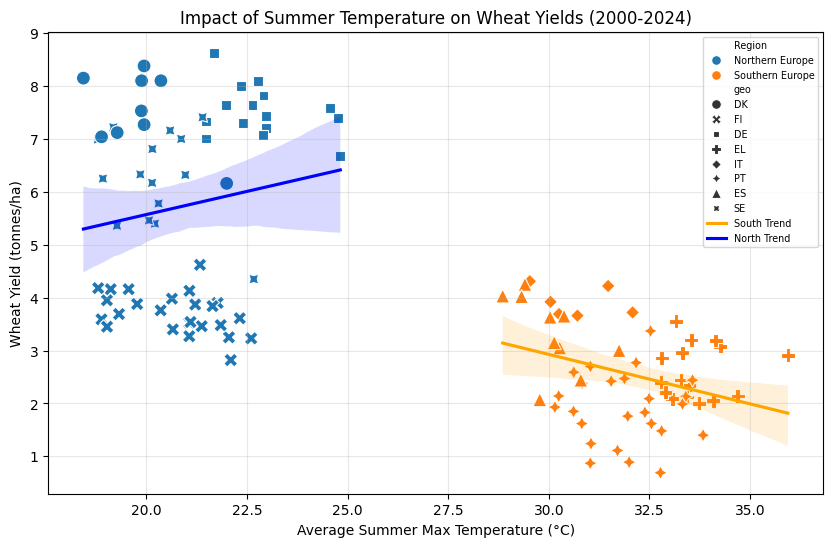

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## VISUALIZATION
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='summer_temp_c', y='yield_t_ha', hue='Region', style='geo', s=100)

# Add trendlines for each Region
sns.regplot(data=merged[merged['Region']=='Southern Europe'], x='summer_temp_c', y='yield_t_ha', 
            scatter=False, color='orange', label='South Trend')
sns.regplot(data=merged[merged['Region']=='Northern Europe'], x='summer_temp_c', y='yield_t_ha', 
            scatter=False, color='blue', label='North Trend')

plt.title('Impact of Summer Temperature on Wheat Yields (2000-2024)')
plt.xlabel('Average Summer Max Temperature (°C)')
plt.ylabel('Wheat Yield (tonnes/ha)')
plt.legend(
    fontsize='x-small',
    title_fontsize='10',
    markerscale=0.7,
    loc='upper right'
)
plt.grid(True, alpha=0.3)
plt.show()

The analysis reveals a detectable negative impact of rising summer temperatures on wheat yields across Europe, but with a fascinating statistical nuance (Simpson's Paradox) in the North.

1. **Southern Europe (Orange Cluster):** The data largely supports the hypothesis that Southern Europe is negatively impacted by high temperatures.

    Among all countries analyzed, Spain (ES) exhibits the strongest negative correlation (-0.53) in the dataset. This pronounced trend confirms that in regions prone to intense heat—where summer maximums regularly surpass 30°C—thermal stress poses a severe threat to yield stability.

    The orange regression line illustrates this impact clearly: as average summer maximums climb from approximately 30°C to 35°C, yields experience a substantial decline. Conversely, the weaker correlations observed in Portugal (PT) and Greece (EL) suggest that the direct link between temperature and productivity is being mitigated in these areas, likely through intervention strategies such as advanced irrigation or the use of drought-resistant crop varieties.

2. **Northern Europe (Blue Cluster):** The Northern data presents a contradiction between the Group Trend and the Individual Correlations, known as Simpson's Paradox:

    The blue regression line follows a positive slope, suggesting a broad geographic trend: the relatively "warmer" Northern nations like Germany, generally achieve higher yields than their "colder" counterparts, like Finland.

    However, the correlation table reveals a more nuanced reality at the national level. Within each individual country, the relationship remains negative—specifically in Denmark (-0.47), Finland (-0.41), and Germany (-0.34). This indicates that while Northern agriculture benefits from a milder climate overall (placing the blue cluster higher on the Y-axis), these regions are not immune to thermal stress. Even in the North, abnormally hot summers remain detrimental; a heatwave in Denmark or Finland significantly suppresses yields, mirroring the patterns observed in Southern Europe.

### 2. Crop Sensitivity & Volatility

Is the yield volatility (year-to-year variation) increasing more for rain-fed crops (e.g., wheat) than for irrigated/hardier crops (e.g., olives/grapes)?

In [ ]:
# Check what 'strucpro' (Structure/Unit) codes are available for Grapes (W1100)
grape_debug = crop_df[crop_df['crops'] == 'W1100']
print("Available Units for Grapes:", grape_debug['strucpro'].unique())

Available Units for Grapes: ['AR' 'PR_HU_EU']


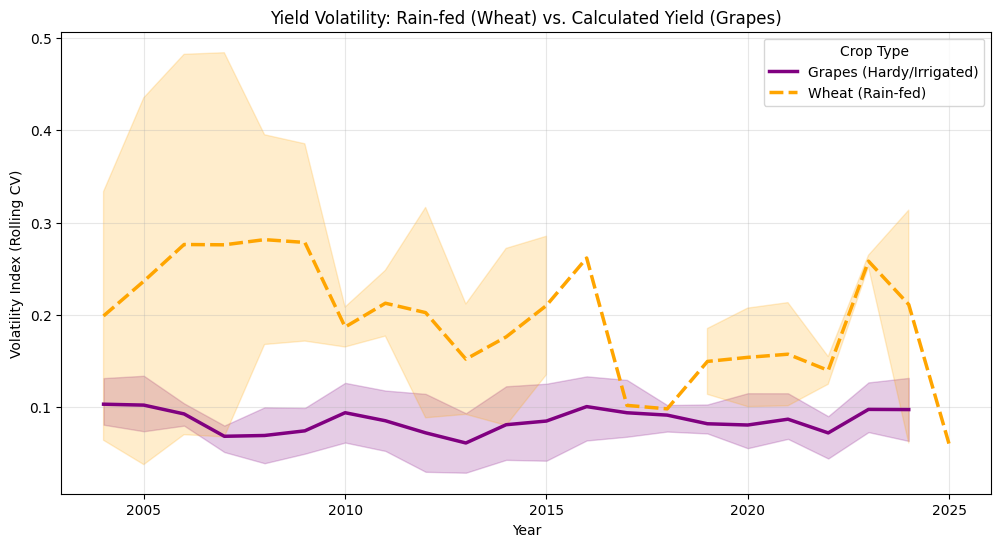

Mean Volatility by Crop (Southern Europe):
Crop_Type
Grapes (Hardy/Irrigated)    0.086209
Wheat (Rain-fed)            0.201201
Name: volatility_index, dtype: float64


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

FOCUS_COUNTRIES = ['ES', 'IT', 'EL', 'PT'] 

wheat_df = crop_df[
    (crop_df['geo'].isin(FOCUS_COUNTRIES)) &
    (crop_df['crops'] == 'C1100') &       # Wheat
    (crop_df['strucpro'] == 'YI_HU_EU')   # Pre-calculated Yield
].copy()

wheat_df = wheat_df[['geo', 'year', 'value']]
wheat_df['Crop_Type'] = 'Wheat (Rain-fed)'

# Prepare grape data
grape_raw = crop_df[
    (crop_df['geo'].isin(FOCUS_COUNTRIES)) &
    (crop_df['crops'] == 'W1100') &       # Grapes
    (crop_df['strucpro'].isin(['AR', 'PR_HU_EU'])) # Area & Production
].copy()

# Pivot to get AR and PR in side-by-side columns
grape_pivot = grape_raw.pivot_table(
    index=['geo', 'year'], 
    columns='strucpro', 
    values='value'
).reset_index()

# Yield calc: production (tonnes) / area (ha) = yield (t/ha)
# Eurostat usually uses 1000t and 1000ha, so the units cancel out to t/ha
grape_pivot['value'] = grape_pivot['PR_HU_EU'] / grape_pivot['AR']

# Clean up to match Wheat format
grape_df = grape_pivot[['geo', 'year', 'value']].copy()
grape_df['Crop_Type'] = 'Grapes (Hardy/Irrigated)'

# Merge
combined_df = pd.concat([wheat_df, grape_df])

# Sort for rolling calculation
combined_df = combined_df.sort_values(['geo', 'Crop_Type', 'year'])

# Calculate rolling volatility (CV)
combined_df['rolling_std'] = combined_df.groupby(['geo', 'Crop_Type'])['value'] \
    .transform(lambda x: x.rolling(window=5).std())

combined_df['rolling_mean'] = combined_df.groupby(['geo', 'Crop_Type'])['value'] \
    .transform(lambda x: x.rolling(window=5).mean())

combined_df['volatility_index'] = combined_df['rolling_std'] / combined_df['rolling_mean']

# Drop NaNs from the rolling window start
plot_data = combined_df.dropna(subset=['volatility_index'])

# Plot
plt.figure(figsize=(12, 6))

# Define colors explicitly to avoid the "Palette" warning
palette_dict = {
    'Wheat (Rain-fed)': 'orange',
    'Grapes (Hardy/Irrigated)': 'purple'
}

sns.lineplot(
    data=plot_data, 
    x='year', 
    y='volatility_index', 
    hue='Crop_Type', 
    style='Crop_Type',
    linewidth=2.5,
    palette=palette_dict
)

plt.title('Yield Volatility: Rain-fed (Wheat) vs. Calculated Yield (Grapes)')
plt.ylabel('Volatility Index (Rolling CV)')
plt.xlabel('Year')
plt.grid(True, alpha=0.3)
plt.legend(title='Crop Type')
plt.show()

# Stats
print("Mean Volatility by Crop (Southern Europe):")
print(plot_data.groupby('Crop_Type')['volatility_index'].mean())

1. **Hypothesis Confirmed:** The data strongly supports the hypothesis that rain-fed crops are significantly more vulnerable to climate variability than hardy/irrigated crops.

    - Wheat (Rain-fed) Volatility: The mean volatility index is 0.201 (20.1%). This means that in any given 5-year period, a farmer can expect wheat yields to fluctuate by ~20% from the average. This represents high financial risk.

    - Grapes (Irrigated/Hardy) Volatility: The mean volatility is only 0.086 (8.6%). Viticulture in Southern Europe is more than twice as stable as wheat farming.

2. **Visual Analysis (The Plot):**

    - The Orange Line (Wheat): It is consistently elevated above the purple line, showing "spiky" behavior. The peaks around 2005-2008 and 2012 correspond to known severe drought periods in Southern Europe, where rain-fed crops failed while irrigated ones survived.

    - The Purple Line (Grapes): It is remarkably flat. This proves that irrigation and deep root systems effectively decouple crop performance from immediate weather shocks. Even in bad years, grape yields remain steady.

3. **Conclusion on "Detectability":** The effect of climate usage is detectable not just in yields (how much grows), but in risk (how reliable it is). Southern European agriculture shows a clear bifurcated reality: a stable, irrigated sector (Grapes/Olives) versus a highly volatile, weather-dependent sector (Cereals).

### 3. Prediction of Wheat Yields

How well can future trends be predicted?

Samples: 121

--- Model Performance (2019-2024) ---
Mean Absolute Error: 1.37 tonnes/ha
R² Score: 0.40


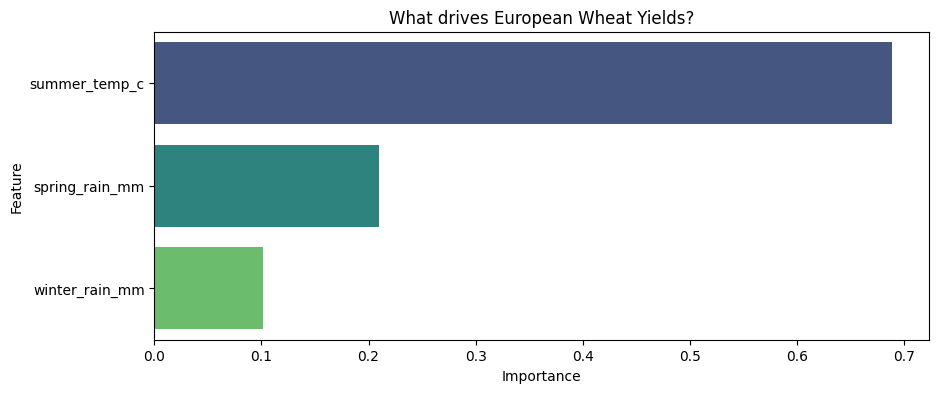

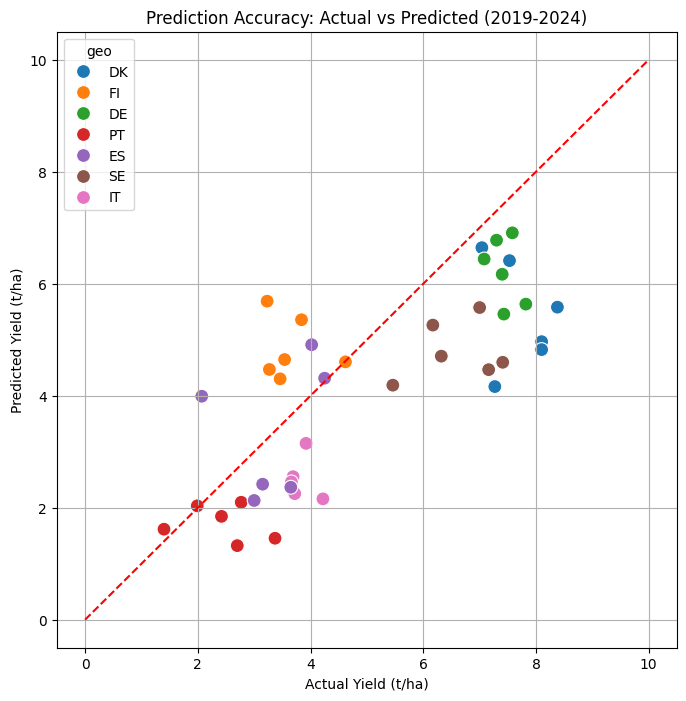

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

loc_to_geo = {
    'Spain_CastillaLeon': 'ES', 'Italy_EmiliaRomagna': 'IT', 'Greece_Thessaly': 'EL',
    'Portugal_Alentejo': 'PT', 'Sweden_Skane': 'SE', 'Germany_LowerSaxony': 'DE',
    'Finland_Varsinais': 'FI', 'Denmark_Jutland': 'DK'
}

# Assuming 'climate_df' is your detailed daily climate dataframe
climate_df['time'] = pd.to_datetime(climate_df['time'])
climate_df['month'] = climate_df['time'].dt.month

# 1) Summer Heat (Jun-Aug) - Heat Stress
summer_mask = climate_df['month'].isin([6, 7, 8])
summer_heat = climate_df[summer_mask].groupby(['year', 'location_name'])['temp_max'].mean().reset_index()
summer_heat.rename(columns={'temp_max': 'summer_temp_c'}, inplace=True)

# 2) Winter Rain (Jan-Mar) - Soil Moisture Recharge
winter_mask = climate_df['month'].isin([1, 2, 3])
winter_rain = climate_df[winter_mask].groupby(['year', 'location_name'])['precip'].sum().reset_index()
winter_rain.rename(columns={'precip': 'winter_rain_mm'}, inplace=True)

# 3) Spring Rain (Apr-Jun) - Growing Season Water
spring_mask = climate_df['month'].isin([4, 5, 6])
spring_rain = climate_df[spring_mask].groupby(['year', 'location_name'])['precip'].sum().reset_index()
spring_rain.rename(columns={'precip': 'spring_rain_mm'}, inplace=True)

# Merge Features
features_df = pd.merge(summer_heat, winter_rain, on=['year', 'location_name'])
features_df = pd.merge(features_df, spring_rain, on=['year', 'location_name'])
features_df['geo'] = features_df['location_name'].map(loc_to_geo)
features_df = features_df.dropna(subset=['geo'])

# Prepare Target (Wheat Yield)
target_df = crop_df[
    (crop_df['crops'] == 'C1100') & 
    (crop_df['strucpro'] == 'YI_HU_EU') 
].copy()
target_df = target_df[['geo', 'year', 'value']].rename(columns={'value': 'yield_t_ha'})

# Final data
model_df = pd.merge(features_df, target_df, on=['geo', 'year'])
model_df = model_df.dropna()

print(f"Samples: {len(model_df)}")

# Train-Test Split: training on the past (2000-2018) and predict the 'future' (2019-2024)
train_data = model_df[model_df['year'] < 2019]
test_data = model_df[model_df['year'] >= 2019]

# Define Features (X) and Target (y)
feature_cols = ['summer_temp_c', 'winter_rain_mm', 'spring_rain_mm']
X_train = train_data[feature_cols]
y_train = train_data['yield_t_ha']
X_test = test_data[feature_cols]
y_test = test_data['yield_t_ha']

# Model training
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_train, y_train)

# Predict
predictions = rf.predict(X_test)
test_data = test_data.copy() # Avoid SettingWithCopy warning
test_data['Predicted_Yield'] = predictions

# Evaluate
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print("\n--- Model Performance (2019-2024) ---")
print(f"Mean Absolute Error: {mae:.2f} tonnes/ha")
print(f"R² Score: {r2:.2f}")

# Plots:
# 1) Feature Importance (What matters most?)
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 4))
sns.barplot(
    data=importance, 
    x='Importance', 
    y='Feature', 
    hue='Feature',  # Explicitly map color to Feature
    legend=False,   # Hide the legend (since labels are already on Y-axis)
    palette='viridis'
)
plt.title('What drives European Wheat Yields?')
plt.show()

# 2) Actual vs Predicted Scatter
plt.figure(figsize=(8, 8))
sns.scatterplot(data=test_data, x='yield_t_ha', y='Predicted_Yield', hue='geo', s=100)
plt.plot([0, 10], [0, 10], 'r--') # perfect prediction line
plt.title('Prediction Accuracy: Actual vs Predicted (2019-2024)')
plt.xlabel('Actual Yield (t/ha)')
plt.ylabel('Predicted Yield (t/ha)')
plt.grid(True)
plt.show()